In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/FYP/chest_xray_MobileNetV3_Augmentation>.zip -d /content/extracted_files

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras import layers, models, optimizers
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
import matplotlib.pyplot as plt


In [ ]:
# Step 1: Set up paths for the dataset
dataset_dir = "/content/extracted_files/chest_xray_MobileNetV3_Augmentation"

# Define paths for training and testing
train_dir = os.path.join(dataset_dir, "/content/extracted_files/chest_xray_MobileNetV3_Augmentation/train")
test_dir = os.path.join(dataset_dir, "/content/extracted_files/chest_xray_MobileNetV3_Augmentation/test")


In [ ]:
# Image dimensions and batch size
img_height, img_width = 224, 224  # MobileNetV3 recommended input size
batch_size = 32


In [ ]:
# Step 1: Data Augmentation and Loading
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=10,   # Moderate rotation
    width_shift_range=0.05,  # Small width shift
    height_shift_range=0.05, # Small height shift
    zoom_range=0.05,     # Small zoom
    horizontal_flip=True,
    validation_split=0.2  # Reserve 20% of training data for validation
)


In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="binary",
    subset="training"
)


Found 4187 images belonging to 2 classes.


In [ ]:
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="binary",
    subset="validation"
)


Found 1045 images belonging to 2 classes.


In [ ]:
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="binary",
    shuffle=False
)


Found 624 images belonging to 2 classes.


In [ ]:
# Step 2: Compute Class Weights
train_classes = train_generator.classes
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_classes),
    y=train_classes
)
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)


Class Weights: {0: 1.938425925925926, 1: 0.6738010943031864}


In [ ]:
# Step 3: Build MobileNetV3 Model
base_model = MobileNetV3Small(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights="imagenet"
)


In [ ]:
# Freeze base model
base_model.trainable = False


In [ ]:
# Add custom layers
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

In [ ]:
# Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)


In [ ]:
# Print model summary
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ MobileNetV3Small (Functional)        │ (None, 7, 7, 576)           │         939,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 576)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,013,105 (3.86 MB)

 Trainable params: 73,985 (289.00 KB)

 Non-trainable params: 939,120 (3.58 MB)

In [ ]:
# Step 4: Train the Model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,  # Adjust epochs as needed
    verbose=1,
    class_weight=class_weights_dict  # Apply class weights
)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


131/131 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - accuracy: 0.5143 - loss: 0.7043 - val_accuracy: 0.7426 - val_loss: 0.6672
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - accuracy: 0.5566 - loss: 0.6948 - val_accuracy: 0.7426 - val_loss: 0.6513
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 187s 1s/step - accuracy: 0.5765 - loss: 0.7000 - val_accuracy: 0.4660 - val_loss: 0.6951
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 200s 1s/step - accuracy: 0.5230 - loss: 0.6914 - val_accuracy: 0.6239 - val_loss: 0.6902
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 189s 1s/step - accuracy: 0.5920 - loss: 0.6772 - val_accuracy: 0.7397 - val_loss: 0.6702
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 189s 1s/step - accuracy: 0.6062 - loss: 0.6777 - val_accuracy: 0.7234 - val_loss: 0.6677
Epoch 7/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 190s 1s/step - accuracy: 0.5498 - loss: 0.6841 - val_accuracy: 0.3694 - val_loss: 0.7060
Epoch 8/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.6234 - loss: 0.6667 - val_accuracy: 0.258

In [ ]:
# Step 5: Evaluate the Model
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 665ms/step - accuracy: 0.7458 - loss: 0.6082
Test Accuracy: 45.19%


In [ ]:
# Step 6: Predictions and Metrics
y_pred = (model.predict(test_generator) > 0.5).astype("int32")
y_true = test_generator.classes


20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 736ms/step


In [ ]:
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys(), zero_division=0))



Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.41      1.00      0.58       234
   PNEUMONIA       1.00      0.12      0.22       390

    accuracy                           0.45       624
   macro avg       0.70      0.56      0.40       624
weighted avg       0.78      0.45      0.35       624



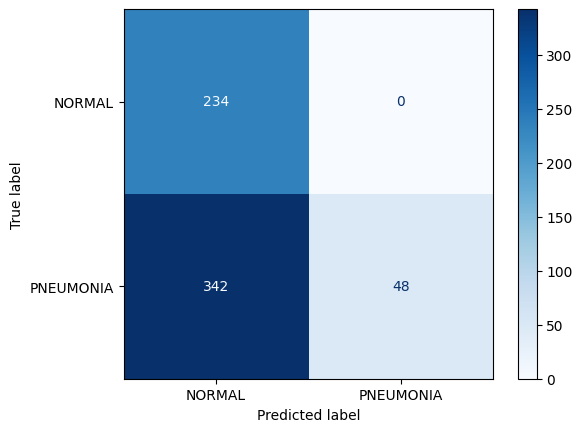

In [ ]:
# Step 7: Confusion Matrix
confusion_mtx = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mtx, display_labels=test_generator.class_indices.keys())
disp.plot(cmap="Blues")
plt.show()


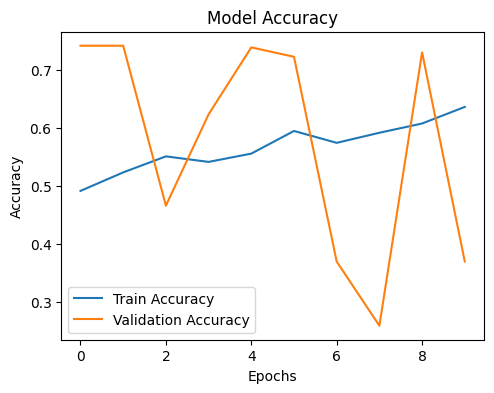

In [ ]:
# Optional: Plot Training History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


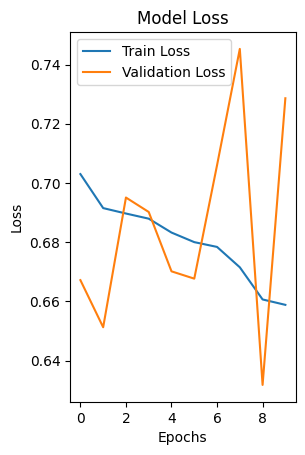

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
